# Введение в анализ данных
## НИУ ВШЭ, 2020-2021 учебный год

### Домашнее задание №8

In [1]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

## Градиентный бустинг своими руками (2 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним основные формулы.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$. Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.

В качестве функции потерь возьмите MSE.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [2]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize

In [125]:
def mse(gamma, y, comp, prediction):
    return mean_squared_error(y, comp + gamma * prediction)  # np.sum(np.square(y - comp - gamma * prediction))

In [136]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        # your code here
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.trees = []
        self.gammas = []
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        # your code here
        trees = []
        y_new = y
        self.a_i = 0
        for i in range(self.n_estimators):
            # your code here
            self.a_i += self._fit_predict_tree(x, y_new)
            y_new = y - self.a_i

    def _fit_predict_tree(self, x, y):
        # Обучаем дерево и возвращаем его предикшн
        tree = DecisionTreeRegressor(criterion='mse', max_depth=self.max_depth).fit(x, y)
        self.trees.append(tree)
        # нахождение минимального шага тут
        gamma = minimize(mse, 1, bounds = ((0.01, 1),),
                         args=(y, self.a_i, tree.predict(x)))
        self.gamma = gamma.x
        self.gammas.append(self.gamma)
        return self.gamma * self.learning_rate * tree.predict(x)
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        # your code here
        y_pred = sum([self.trees[i].predict(x) * self.gammas[i] * self.learning_rate 
                      for i in range(self.n_estimators)])
        return y_pred

Проверьте вашу реализацию на Boston dataset. Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.

In [113]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [114]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [139]:
np.random.seed(19052019)

# your code here
gb = GradientBoosting(n_estimators=10070, max_depth=2, learning_rate=1)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

In [140]:
mean_squared_error(y_test, y_pred)

20.821875658028784

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {XGboost, catboost, LightGBM} и GridSearch для достижения результата. Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.

In [142]:
import pandas as pd

In [143]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_test.csv')

In [144]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [ ]:
# Референс

from xgboost.sklearn import XGBClassifier

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb = XGBClassifier()
xgb_model.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])

In [181]:
from catboost import CatBoostRegressor
X_train = train.drop(columns='dep_delayed_15min')
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values

X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

cbr = CatBoostRegressor(cat_features=[0, 1, 2, 4, 5, 6])
cbr.fit(X_train_part, y_train_part)

Learning rate set to 0.083143
0:	learn: 0.3896125	total: 92.8ms	remaining: 1m 32s
1:	learn: 0.3875650	total: 185ms	remaining: 1m 32s
2:	learn: 0.3857344	total: 319ms	remaining: 1m 45s
3:	learn: 0.3842199	total: 394ms	remaining: 1m 38s
4:	learn: 0.3827652	total: 449ms	remaining: 1m 29s
5:	learn: 0.3815385	total: 524ms	remaining: 1m 26s
6:	learn: 0.3806600	total: 625ms	remaining: 1m 28s
7:	learn: 0.3798236	total: 681ms	remaining: 1m 24s
8:	learn: 0.3789183	total: 773ms	remaining: 1m 25s
9:	learn: 0.3780775	total: 849ms	remaining: 1m 24s
10:	learn: 0.3773928	total: 895ms	remaining: 1m 20s
11:	learn: 0.3767805	total: 953ms	remaining: 1m 18s
12:	learn: 0.3762179	total: 1.04s	remaining: 1m 19s
13:	learn: 0.3755497	total: 1.1s	remaining: 1m 17s
14:	learn: 0.3750516	total: 1.18s	remaining: 1m 17s
15:	learn: 0.3746225	total: 1.26s	remaining: 1m 17s
16:	learn: 0.3741320	total: 1.35s	remaining: 1m 18s
17:	learn: 0.3737004	total: 1.42s	remaining: 1m 17s
18:	learn: 0.3733197	total: 1.49s	remaining:

160:	learn: 0.3618111	total: 15.4s	remaining: 1m 20s
161:	learn: 0.3617961	total: 15.4s	remaining: 1m 19s
162:	learn: 0.3617578	total: 15.5s	remaining: 1m 19s
163:	learn: 0.3617363	total: 15.6s	remaining: 1m 19s
164:	learn: 0.3617047	total: 15.7s	remaining: 1m 19s
165:	learn: 0.3616916	total: 15.8s	remaining: 1m 19s
166:	learn: 0.3616404	total: 15.9s	remaining: 1m 19s
167:	learn: 0.3616072	total: 16s	remaining: 1m 19s
168:	learn: 0.3615398	total: 16.1s	remaining: 1m 19s
169:	learn: 0.3614865	total: 16.2s	remaining: 1m 19s
170:	learn: 0.3614411	total: 16.3s	remaining: 1m 19s
171:	learn: 0.3614101	total: 16.4s	remaining: 1m 18s
172:	learn: 0.3613632	total: 16.4s	remaining: 1m 18s
173:	learn: 0.3613427	total: 16.5s	remaining: 1m 18s
174:	learn: 0.3613040	total: 16.5s	remaining: 1m 18s
175:	learn: 0.3612758	total: 16.6s	remaining: 1m 17s
176:	learn: 0.3612523	total: 16.7s	remaining: 1m 17s
177:	learn: 0.3612261	total: 16.8s	remaining: 1m 17s
178:	learn: 0.3611999	total: 16.8s	remaining: 1m

317:	learn: 0.3576515	total: 29.7s	remaining: 1m 3s
318:	learn: 0.3576052	total: 29.8s	remaining: 1m 3s
319:	learn: 0.3575890	total: 29.9s	remaining: 1m 3s
320:	learn: 0.3575412	total: 30s	remaining: 1m 3s
321:	learn: 0.3575186	total: 30s	remaining: 1m 3s
322:	learn: 0.3575048	total: 30.1s	remaining: 1m 3s
323:	learn: 0.3574604	total: 30.2s	remaining: 1m 2s
324:	learn: 0.3574455	total: 30.2s	remaining: 1m 2s
325:	learn: 0.3574038	total: 30.3s	remaining: 1m 2s
326:	learn: 0.3573724	total: 30.3s	remaining: 1m 2s
327:	learn: 0.3573573	total: 30.4s	remaining: 1m 2s
328:	learn: 0.3573366	total: 30.5s	remaining: 1m 2s
329:	learn: 0.3573284	total: 30.6s	remaining: 1m 2s
330:	learn: 0.3573215	total: 30.6s	remaining: 1m 1s
331:	learn: 0.3573087	total: 30.7s	remaining: 1m 1s
332:	learn: 0.3573041	total: 30.8s	remaining: 1m 1s
333:	learn: 0.3572922	total: 30.8s	remaining: 1m 1s
334:	learn: 0.3572783	total: 30.9s	remaining: 1m 1s
335:	learn: 0.3572385	total: 31s	remaining: 1m 1s
336:	learn: 0.3572

479:	learn: 0.3547619	total: 40.5s	remaining: 43.9s
480:	learn: 0.3547461	total: 40.6s	remaining: 43.8s
481:	learn: 0.3547367	total: 40.6s	remaining: 43.7s
482:	learn: 0.3547349	total: 40.7s	remaining: 43.6s
483:	learn: 0.3547288	total: 40.8s	remaining: 43.5s
484:	learn: 0.3547098	total: 40.8s	remaining: 43.4s
485:	learn: 0.3546986	total: 40.9s	remaining: 43.2s
486:	learn: 0.3546892	total: 40.9s	remaining: 43.1s
487:	learn: 0.3546760	total: 41s	remaining: 43.1s
488:	learn: 0.3546596	total: 41.1s	remaining: 43s
489:	learn: 0.3546522	total: 41.2s	remaining: 42.9s
490:	learn: 0.3546366	total: 41.3s	remaining: 42.8s
491:	learn: 0.3546197	total: 41.3s	remaining: 42.7s
492:	learn: 0.3546056	total: 41.4s	remaining: 42.6s
493:	learn: 0.3545804	total: 41.4s	remaining: 42.4s
494:	learn: 0.3545779	total: 41.5s	remaining: 42.3s
495:	learn: 0.3545595	total: 41.5s	remaining: 42.2s
496:	learn: 0.3545440	total: 41.6s	remaining: 42.1s
497:	learn: 0.3545346	total: 41.7s	remaining: 42s
498:	learn: 0.3545

638:	learn: 0.3522906	total: 51s	remaining: 28.8s
639:	learn: 0.3522737	total: 51.1s	remaining: 28.8s
640:	learn: 0.3522608	total: 51.2s	remaining: 28.7s
641:	learn: 0.3522367	total: 51.3s	remaining: 28.6s
642:	learn: 0.3522310	total: 51.3s	remaining: 28.5s
643:	learn: 0.3522173	total: 51.4s	remaining: 28.4s
644:	learn: 0.3522036	total: 51.5s	remaining: 28.3s
645:	learn: 0.3521747	total: 51.5s	remaining: 28.2s
646:	learn: 0.3521615	total: 51.6s	remaining: 28.1s
647:	learn: 0.3521460	total: 51.6s	remaining: 28.1s
648:	learn: 0.3521315	total: 51.7s	remaining: 28s
649:	learn: 0.3521177	total: 51.8s	remaining: 27.9s
650:	learn: 0.3521095	total: 51.8s	remaining: 27.8s
651:	learn: 0.3521044	total: 51.9s	remaining: 27.7s
652:	learn: 0.3520671	total: 52s	remaining: 27.6s
653:	learn: 0.3520530	total: 52.1s	remaining: 27.5s
654:	learn: 0.3520469	total: 52.2s	remaining: 27.5s
655:	learn: 0.3520298	total: 52.2s	remaining: 27.4s
656:	learn: 0.3520161	total: 52.3s	remaining: 27.3s
657:	learn: 0.3520

798:	learn: 0.3500795	total: 1m 5s	remaining: 16.4s
799:	learn: 0.3500579	total: 1m 5s	remaining: 16.4s
800:	learn: 0.3500395	total: 1m 5s	remaining: 16.3s
801:	learn: 0.3500316	total: 1m 5s	remaining: 16.2s
802:	learn: 0.3500254	total: 1m 5s	remaining: 16.1s
803:	learn: 0.3500123	total: 1m 5s	remaining: 16s
804:	learn: 0.3500048	total: 1m 5s	remaining: 15.9s
805:	learn: 0.3499966	total: 1m 5s	remaining: 15.9s
806:	learn: 0.3499900	total: 1m 6s	remaining: 15.8s
807:	learn: 0.3499811	total: 1m 6s	remaining: 15.7s
808:	learn: 0.3499675	total: 1m 6s	remaining: 15.6s
809:	learn: 0.3499537	total: 1m 6s	remaining: 15.5s
810:	learn: 0.3499516	total: 1m 6s	remaining: 15.5s
811:	learn: 0.3499456	total: 1m 6s	remaining: 15.4s
812:	learn: 0.3499421	total: 1m 6s	remaining: 15.3s
813:	learn: 0.3499335	total: 1m 6s	remaining: 15.2s
814:	learn: 0.3499193	total: 1m 6s	remaining: 15.1s
815:	learn: 0.3499051	total: 1m 6s	remaining: 15s
816:	learn: 0.3499005	total: 1m 6s	remaining: 15s
817:	learn: 0.3498

957:	learn: 0.3483337	total: 1m 18s	remaining: 3.42s
958:	learn: 0.3483272	total: 1m 18s	remaining: 3.34s
959:	learn: 0.3483130	total: 1m 18s	remaining: 3.26s
960:	learn: 0.3483075	total: 1m 18s	remaining: 3.17s
961:	learn: 0.3482960	total: 1m 18s	remaining: 3.09s
962:	learn: 0.3482674	total: 1m 18s	remaining: 3.01s
963:	learn: 0.3482639	total: 1m 18s	remaining: 2.93s
964:	learn: 0.3482559	total: 1m 18s	remaining: 2.85s
965:	learn: 0.3482427	total: 1m 18s	remaining: 2.76s
966:	learn: 0.3481884	total: 1m 18s	remaining: 2.68s
967:	learn: 0.3481684	total: 1m 18s	remaining: 2.6s
968:	learn: 0.3481618	total: 1m 18s	remaining: 2.52s
969:	learn: 0.3481424	total: 1m 18s	remaining: 2.44s
970:	learn: 0.3481329	total: 1m 18s	remaining: 2.36s
971:	learn: 0.3481278	total: 1m 19s	remaining: 2.27s
972:	learn: 0.3481040	total: 1m 19s	remaining: 2.19s
973:	learn: 0.3480891	total: 1m 19s	remaining: 2.11s
974:	learn: 0.3480830	total: 1m 19s	remaining: 2.03s
975:	learn: 0.3480677	total: 1m 19s	remaining: 

In [183]:
y_pred = np.array(cbr.predict(X_valid))
roc_auc_score(y_valid, y_pred)

0.7579039253609601

## DBSCAN своими руками (2 + 2* баллов)

DBSCAN: Density-based spatial clustering of applications with noise

Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [257]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance

In [538]:
# Рекомендации -- это только рекомендации
class dbscan:
    def __init__(self, eps, min_samples):
        # your code here
        self.eps = eps
        self.min_samples = min_samples
        
    def fit_predict(self, X):
        # Помечаем переданные точки, чтобы отличать уже кластеризованные
        # или являющиеся шумом от остальных
        # your code here
        '''all points are saved'''
        self.X = X
        '''labels of all point are default None'''
        self.labels = len(X) * [None]
        ''' 0 clusters are found at the beginning'''
        self.clusters = 0
        # Реализуем цикл по точкам, игнорирущий уже кластеризованные
        # your code here
        # Если точка ещё не кластеризована, с помощью range_query() ищем её соседей
        # Если соседей недостаточно, то помечаем её выделенным под шум лейблом
        # (однако она ещё может попасть в какой-то иной кластер)
        # Если же соседей достаточно, будем строить от неё кластер с помощью grow_cluster()
        # your code here
        '''for each point in all points we have'''
        for i in range(len(X)):
            if self.labels[i] is None:
                neighbours = self.range_query(X[i])
                # if point is a noise
                if len(neighbours) < self.min_samples:
                    self.labels[i] = -1
                else:
                    # if point isn't noise, we make it a new cluster
                    self.clusters += 1
                    self.labels[i] = self.clusters
                    self.grow_cluster(X[i], neighbours)
        
        return self.labels

    def grow_cluster(self, root, neighbours):
        # В этой функции мы полностью строим кластер относительно переданной точки
        # Т.е. реализуем цикл по структуре данных, изначально состоящей из уже
        # известных соседей (neighbours) и в процессе пополняющейся
        # "соседями соседей" с помощью range_query()
        # your code here
        j = 0
        while j < len(neighbours):
            index = np.where(self.X == neighbours[j])[0][0]
            if self.labels[index] == -1:
                self.labels[index] = self.clusters
            elif self.labels[index] != None:
                pass
            else:
                self.labels[index] = self.clusters
                nb = self.range_query(neighbours[j])
                if len(nb) >= self.min_samples:
                    for el in nb:
                        if el not in neighbours:
                            neighbours.append(el)
            j += 1

    def range_query(self, x):
        """Возвращает точки на расстоянии <= eps от x"""
        # С помощью функции dist()
        # your code here
        nb = []
        for point in self.X:
            if list(point) != list(x) and self.dist(point, x) <= self.eps:
                nb.append(list(point))
        return nb
    
    @staticmethod
    def dist(a, b):
        """Метрика расстояния"""
        # Попробуйте что-нибудь из scipy.spatial.distance
        # Базовый вариант -- Евклидова метрика
        # your code here
        a = [a]
        b = [b]
        return distance.cdist(a, b, 'euclidean')[0][0]

Проверим себя на простом примере:

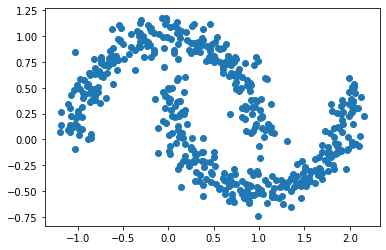

In [456]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

In [457]:
# your code here
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

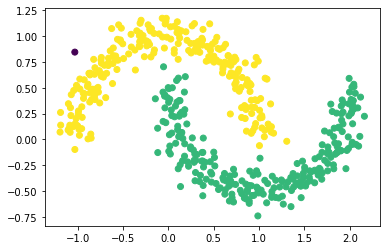

In [458]:
plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Референс:

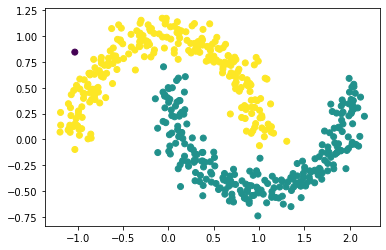

In [459]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):

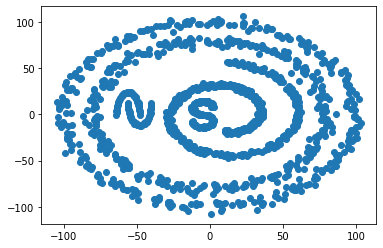

In [ ]:
# your code here


/Users/katyona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/katyona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/Users/katyona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  
/Users/katyona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app
/Users/katyona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt
/Users/katyona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt


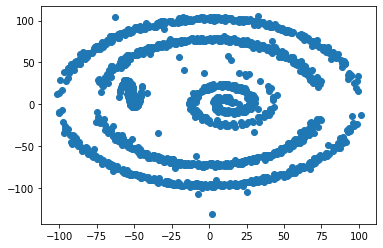

In [552]:
# your code here
xmoontop = np.linspace(-61, -49, num=100) + np.random.rand(100) * 5
ymoontop = (1 - np.square((xmoontop + 55) / 5)) ** (1/2) * 25 + np.random.rand(100) * 5

xmoonbottom = np.linspace(-57, -44, num=100) + np.random.rand(100) * 5
ymoonbottom = - (1 - np.square((xmoonbottom + 50) / 5)) ** (1/2) * 25 + 20 + np.random.rand(100) * 5

tspiral = np.linspace(0, 3*np.pi, num=300) + np.random.rand(300) * 5
xspiral = 2.5 * tspiral * np.cos(tspiral) + 10 + np.random.rand(300) * 5
yspiral = 2.5 * tspiral * np.sin(tspiral) + np.random.rand(300) * 5

xsmalltop = np.linspace(-77, 76, num=300) + np.random.rand(300) * 5
xsmallbottom = np.linspace(-77, 76, num=300) + np.random.rand(300) * 5
ysmalltop = (75**2 - np.square(xsmall)) ** (1/2) + np.random.rand(300) * 5
ysmallbottom = - (75**2 - np.square(xsmall)) ** (1/2) + np.random.rand(300) * 5
xbigtop = np.linspace(-102, 101, num=300) + np.random.rand(300) * 5
xbigbottom = np.linspace(-102, 101, num=300) + np.random.rand(300) * 5
ybigtop = (10000 - np.square(xbig)) ** (1/2) + np.random.rand(300) * 5
ybigbottom = - (10000 - np.square(xbig)) ** (1/2) + np.random.rand(300) * 5

xshum = xspiral[::10] * 2 + np.random.rand(30) * 50 - 50
yshum = np.linspace(-100, 100, num=30) + np.random.rand(30) * 100 - 50

X = np.concatenate((xmoontop, xmoonbottom, xspiral, xsmalltop, xsmallbottom, xbigtop, xbigbottom, xshum), axis=0)
Y = np.concatenate((ymoontop, ymoonbottom, yspiral, ysmalltop, ysmallbottom, ybigtop, ybigbottom, yshum), axis=0)
plt.scatter(X, Y)
plt.show()

In [553]:
x = np.concatenate((X, Y), axis=0)
x = x.reshape(2, X.shape[0]).T

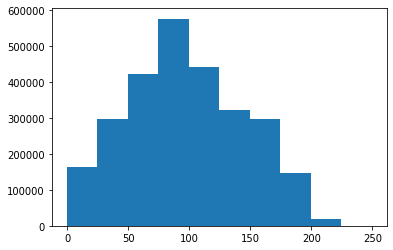

In [549]:
dists = []
for a in x:
    for b in x:
        if list(a) != list(b):
            dists.append(dist([a], [b]))

plt.hist(dists)
plt.show()

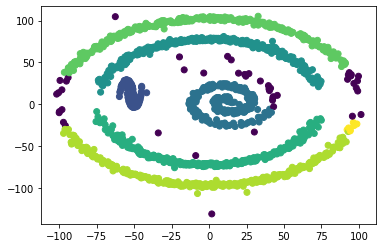

In [558]:
clusters = dbscan(eps=8, min_samples=8).fit_predict(x)
plt.scatter(x[:,0], x[:,1], c=clusters)
plt.show()

In [543]:
print(clusters)

[1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

Или хотя бы что-нибудь такое: 

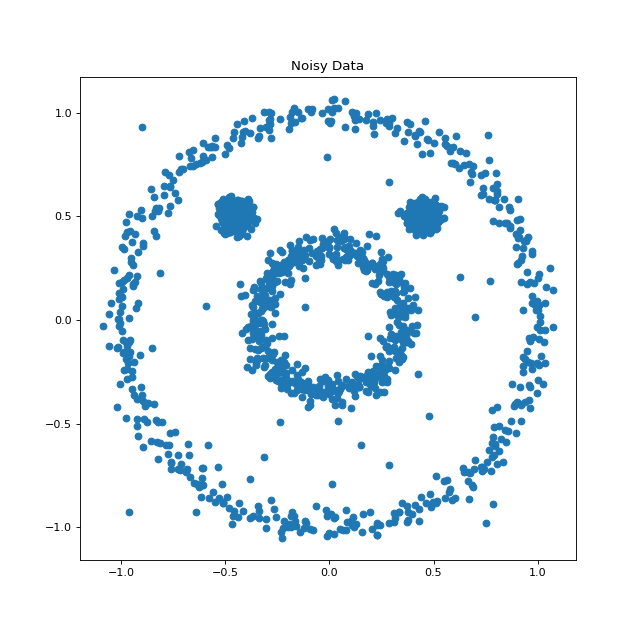

Создадим данные, подобные тем, что представлены на картинке выше

/Users/katyona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/katyona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
/Users/katyona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


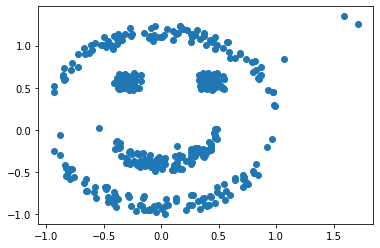

In [452]:
# your code here
xsmile = np.linspace(-0.5, 0.5, num=100) + np.random.rand(100) / 5
ysmile = - (0.25 - np.square(xsmile)) ** (1/2) + np.random.rand(100) / 5

xfaceup = np.linspace(-1, 1, num=100) + np.random.rand(100) / 5
xfacedown = np.linspace(-1, 1, num=100) + np.random.rand(100) / 5
yfaceup = 0.05 + (1 - np.square(xfaceup)) ** (1/2) + np.random.rand(100) / 5
yfacedown = - (1 - np.square(xfacedown)) ** (1/2) + np.random.rand(100) / 5

xeyer = np.linspace(-0.42, -0.35, num=50) + np.random.rand(50) / 5
xeyel = np.linspace(0.3, 0.37, num=50) + np.random.rand(50) / 5

yeyer = np.linspace(0.47, 0.49, num=50) + np.random.rand(50) / 5
yeyel = np.linspace(0.47, 0.49, num=50) + np.random.rand(50) / 5

xshum = np.linspace(-1, 1, num=7) + np.random.rand(7)
yshum = np.linspace(-1, 1, num=7) + np.random.rand(7)

X = np.concatenate((xsmile, xfaceup, xfacedown, xeyer, xeyel, xshum), axis=0)
Y = np.concatenate((ysmile, yfaceup, yfacedown, yeyer, yeyel, yshum), axis=0)
plt.scatter(X, Y)
plt.show()

Приведем эти данные в требуемый вид

In [453]:
x = np.concatenate((X, Y), axis=0)
x = x.reshape(2, X.shape[0]).T

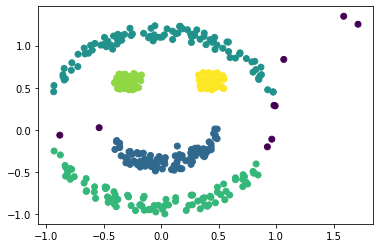

In [454]:
clusters = dbscan(eps=0.2, min_samples=8).fit_predict(x)
plt.scatter(x[:,0], x[:,1], c=clusters)
plt.show()

Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:

In [460]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

CPU times: user 7.12 ms, sys: 1.16 ms, total: 8.27 ms
Wall time: 7 ms


In [461]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

CPU times: user 8.68 s, sys: 61 ms, total: 8.74 s
Wall time: 8.84 s
